In [115]:
import pandas as pd
import numpy as np
import ta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm 
from statsmodels.formula.api import ols


In [116]:
data=pd.read_csv('../data/processed/crypto_data_labeled.csv')
data.head()

,open_time,open,high,low,close,volume,close_time,quote_asset_volume,num_trades,taker_base_volume,...,macd,sma20,sma50,sma200,bb_high,bb_low,stochastic_oscillator,future_return,label,label_name
0,2023-09-12,25162.53,26567.00,25131.48,25840.10,56434.38537,2023-09-12 23:59:59.999,1.464393e+09,1047056,27720.51830,...,-512.111919,26068.5745,27576.7890,27630.36120,27129.522592,25007.626408,32.748983,0.014779,1,HOLD
1,2023-09-13,25840.10,26405.22,25764.17,26222.00,31610.82753,2023-09-13 23:59:59.999,8.254379e+08,714880,15287.00038,...,-448.682032,26070.6720,27516.6508,27645.68585,27132.658711,25008.685289,49.171602,0.011469,1,HOLD
2,2023-09-14,26222.00,26860.49,26126.77,26522.73,38333.17250,2023-09-14 23:59:59.999,1.015267e+09,799278,19440.45467,...,-369.883209,26093.8080,27460.0662,27660.52525,27173.865049,25013.750951,82.762862,0.002913,1,HOLD
3,2023-09-15,26522.73,26888.00,26224.00,26600.00,26227.29369,2023-09-15 23:59:59.999,6.952033e+08,654094,12600.39115,...,-297.767058,26122.9395,27407.6106,27676.06480,27224.395884,25021.483116,85.505788,-0.001516,1,HOLD
4,2023-09-16,26599.99,26777.00,26445.00,26559.67,13960.93351,2023-09-16 23:59:59.999,3.708899e+08,526416,6508.91352,...,-241.089650,26145.8345,27352.5212,27693.15530,27263.495682,25028.173318,83.476095,-0.001211,1,HOLD


In [117]:
# ststistics summary
data.describe()

,open,high,low,close,volume,quote_asset_volume,num_trades,taker_base_volume,taker_quote_volume,1_day_return,...,rsi,macd,sma20,sma50,sma200,bb_high,bb_low,stochastic_oscillator,future_return,label
count,801.000000,801.000000,801.000000,801.000000,801.000000,8.010000e+02,8.010000e+02,801.000000,8.010000e+02,801.000000,...,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,800.000000,801.000000
mean,76626.966392,78001.020974,75222.951723,76710.092434,29745.109409,2.108715e+09,2.895680e+06,14632.948770,1.034963e+09,0.001920,...,55.034210,680.200800,75866.027109,74355.469262,66431.752087,81524.874910,70207.179308,58.748614,0.001889,1.033708
std,27272.369365,27568.199219,26870.041858,27216.725334,19318.522108,1.382096e+09,2.114847e+06,9708.319807,6.900107e+08,0.024760,...,12.595870,1933.794617,27480.003033,27599.137608,25908.107580,28843.013689,26383.362744,27.726069,0.024759,0.570186
min,25162.530000,26397.460000,25131.480000,25840.100000,3282.173520,2.508740e+08,4.217170e+05,1514.419590,1.165812e+08,-0.085387,...,24.133528,-4714.659119,26068.574500,26446.993200,27630.361200,27017.950276,24093.589365,0.451578,-0.085387,0.000000
25%,58874.590000,59944.070000,57493.300000,58973.990000,16644.838540,1.182572e+09,1.402494e+06,8023.435130,5.725400e+08,-0.011171,...,45.644783,-680.293413,59366.788000,59275.800400,43103.317750,64394.668003,53293.626973,35.969439,-0.011175,1.000000
50%,69649.810000,71305.890000,68820.140000,69850.540000,25530.240700,1.772122e+09,2.230255e+06,12502.931168,8.696348e+08,0.000977,...,54.118933,623.209908,68431.127500,66470.023800,63797.686550,73494.163745,63656.596136,62.544587,0.000961,1.000000
75%,102082.830000,104145.760000,99950.770000,102082.830000,37349.447060,2.641768e+09,3.716586e+06,18202.357940,1.301891e+09,0.013092,...,63.305020,1693.728259,100183.488000,98720.407400,90282.572700,107526.939864,93506.060311,83.833875,0.013085,1.000000
max,124658.540000,126199.630000,123084.000000,124658.540000,162065.591860,1.104800e+10,1.201236e+07,77363.263230,5.657171e+09,0.118834,...,87.941054,7019.055192,118285.325500,116632.120400,110444.916800,128011.523790,116672.986260,99.934411,0.118834,2.000000


In [118]:
# check if classes are balanced
data["label"].value_counts()

label
1    540
2    144
0    117
Name: count, dtype: int64

In [119]:
# change datetime to timestamp
data['open_time'] = pd.to_datetime(data['open_time'])
data['close_time'] = pd.to_datetime(data['close_time'])


In [120]:
# check for correlations 
data.corr(numeric_only=True)

,open,high,low,close,volume,quote_asset_volume,num_trades,taker_base_volume,taker_quote_volume,1_day_return,...,rsi,macd,sma20,sma50,sma200,bb_high,bb_low,stochastic_oscillator,future_return,label
open,1.000000,0.998813,0.998332,0.997625,-0.322644,0.201918,0.428885,-0.328077,0.184735,-0.094917,...,-0.134280,0.071702,0.989558,0.969442,0.926990,0.989836,0.979264,-0.109690,-0.088837,-0.077603
high,0.998813,1.000000,0.997901,0.998984,-0.303345,0.223378,0.443647,-0.306909,0.208426,-0.058243,...,-0.123920,0.074132,0.988945,0.968537,0.925566,0.990064,0.977737,-0.097681,-0.089982,-0.079428
low,0.998332,0.997901,1.000000,0.998716,-0.350089,0.170411,0.402563,-0.353147,0.155762,-0.058266,...,-0.117100,0.075307,0.987609,0.967520,0.927097,0.987377,0.977892,-0.088969,-0.088731,-0.079131
close,0.997625,0.998984,0.998716,1.000000,-0.322542,0.200991,0.424228,-0.324678,0.187551,-0.029435,...,-0.110998,0.077217,0.987740,0.967233,0.925516,0.988393,0.977053,-0.080348,-0.092797,-0.081975
volume,-0.322644,-0.303345,-0.350089,-0.322542,1.000000,0.810561,0.423259,0.997125,0.816174,0.057130,...,0.169174,0.184390,-0.334888,-0.360953,-0.401121,-0.308123,-0.360766,0.041193,0.047811,0.054676
quote_asset_volume,0.201918,0.223378,0.170411,0.200991,0.810561,1.000000,0.777605,0.804620,0.996469,0.002463,...,0.076832,0.238640,0.182618,0.144135,0.080419,0.216391,0.143853,-0.018390,-0.004352,0.010320
num_trades,0.428885,0.443647,0.402563,0.424228,0.423259,0.777605,1.000000,0.411643,0.762631,-0.061894,...,-0.072058,0.101148,0.425741,0.402225,0.393825,0.454644,0.389845,-0.127814,-0.002179,0.011288
taker_base_volume,-0.328077,-0.306909,-0.353147,-0.324678,0.997125,0.804620,0.411643,1.000000,0.816217,0.106743,...,0.195883,0.195704,-0.341703,-0.368618,-0.408257,-0.314592,-0.367892,0.070530,0.045507,0.051827
taker_quote_volume,0.184735,0.208426,0.155762,0.187551,0.816174,0.996469,0.762631,0.816217,1.000000,0.054528,...,0.108913,0.252620,0.163801,0.124307,0.061810,0.198152,0.124593,0.015114,-0.004682,0.009357
1_day_return,-0.094917,-0.058243,-0.058266,-0.029435,0.057130,0.002463,-0.061894,0.106743,0.054528,1.000000,...,0.356800,0.070337,-0.086860,-0.090617,-0.077480,-0.081815,-0.091499,0.434593,-0.061657,-0.062497


In [121]:
# drop columns that may cause data leakage
data.drop(columns=['future_return','open_time', 'close_time', 'quote_asset_volume'], inplace=True)


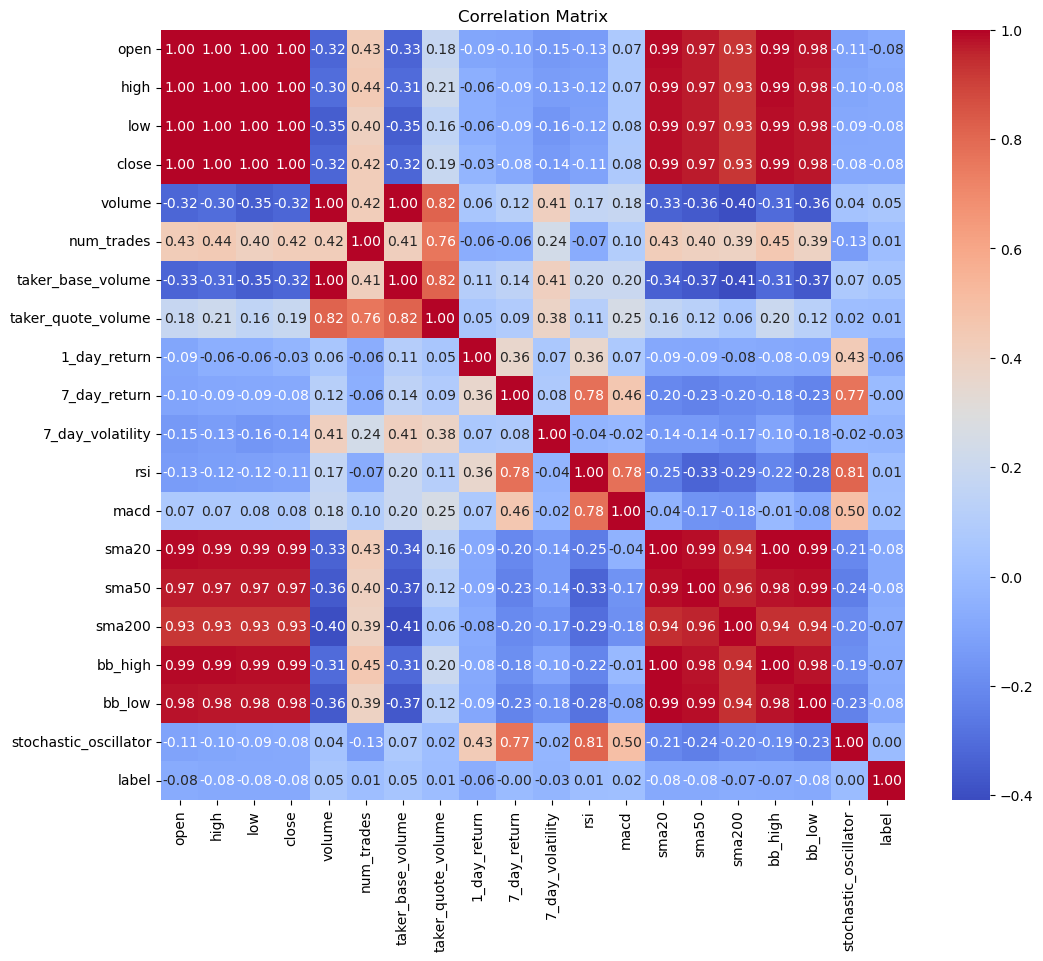

In [122]:
# correlation of numeric columns only
corr_matrix = data.corr(numeric_only=True)
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [123]:
# check for multicollinearity using VIF
X = data.select_dtypes(include=['float64', 'int64'])
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif_data)


                  feature           VIF
0                    open  3.455905e+04
1                    high  2.158829e+04
2                     low  1.462599e+04
3                   close  3.293299e+04
4                  volume  1.230922e+03
5              num_trades  1.365626e+01
6       taker_base_volume  1.286219e+03
7      taker_quote_volume  8.852501e+01
8            1_day_return  1.314557e+01
9            7_day_return  4.698571e+00
10       7_day_volatility  8.322870e+00
11                    rsi  7.232247e+01
12                   macd  4.732738e+01
13                  sma20           inf
14                  sma50  5.905221e+03
15                 sma200  1.299330e+02
16                bb_high           inf
17                 bb_low           inf
18  stochastic_oscillator  2.707258e+01
19                  label  4.336922e+00


c:\Users\user\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [124]:
# Perform ststistical test for significance
formula="close~ open+high+low+volume+num_trades+taker_base_volume+taker_quote_volume+rsi+macd+sma20+sma50+sma200+bb_high+bb_low+stochastic_oscillator+C(label)"
lm=ols(formula=formula,data=data).fit()
table=sm.stats.anova_lm(lm,typ=2)
print(table)


                             sum_sq     df           F        PR(>F)
C(label)               2.175558e+06    2.0    2.735413  6.548638e-02
open                   8.856412e+07    1.0  222.710184  1.635496e-44
high                   1.182468e+08    1.0  297.352620  9.777934e-57
low                    1.302845e+08    1.0  327.623463  1.884078e-61
volume                 4.415342e+06    1.0   11.103160  9.021917e-04
num_trades             4.313949e+06    1.0   10.848189  1.033281e-03
taker_base_volume      2.916479e+06    1.0    7.334003  6.913671e-03
taker_quote_volume     6.006665e+06    1.0   15.104824  1.103024e-04
rsi                    9.279770e+06    1.0   23.335627  1.636570e-06
macd                   3.904384e+07    1.0   98.182655  6.919244e-22
sma20                  5.128914e+07    1.0  128.975637  8.876010e-28
sma50                  3.137673e+07    1.0   78.902359  4.402301e-18
sma200                 8.433512e+05    1.0    2.120756  1.457151e-01
bb_high                1.755480e+0

In [125]:
# define feature columns and target variables,removing all correlated columns from the heatmap
feature_cols =[ 'close', 'volume','num_trades' ,'1_day_return','7_day_volatility','stochastic_oscillator', 'macd', 'sma20', 'bb_high' ]


# create feature matrix X and target y
X = data[feature_cols]
y = data['label']

In [126]:

# Use: - 70% training - 15% validation - 15% test\
# **No shuffling** because cryptocurrency is time-series.
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.15)
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]
print(f'Training set size: {X_train.shape}, Validation set size: {X_val.shape}, Test set size: {X_test.shape}')



Training set size: (560, 9), Validation set size: (120, 9), Test set size: (121, 9)


In [128]:
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns

scaler = StandardScaler()
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])


In [129]:
# balance the classes 
smote = SMOTE()   # safe for time series because it does NOT shuffle
X_train_resampled, y_train_resampled = smote.fit_resample(X_train,y_train)

In [130]:
print(y_train_resampled.value_counts())


label
1    359
0    359
2    359
Name: count, dtype: int64


In [131]:
from sklearn.ensemble import RandomForestClassifier


rf = RandomForestClassifier()
rf.fit(X_train_resampled, y_train_resampled)
pred_rf = rf.predict(X_test)

print("Random Forest:")
print(classification_report(y_test, pred_rf))


Random Forest:
              precision    recall  f1-score   support

           0       0.16      0.32      0.21        19
           1       0.72      0.64      0.68        90
           2       0.00      0.00      0.00        12

    accuracy                           0.53       121
   macro avg       0.29      0.32      0.30       121
weighted avg       0.56      0.53      0.54       121



In [132]:
import lightgbm as lgb

lgbm = lgb.LGBMClassifier()
lgbm.fit(X_train_resampled, y_train_resampled)
pred_lgbm = lgbm.predict(X_test)

print("LightGBM:")
print(classification_report(y_test, pred_lgbm))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000987 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 1077, number of used features: 9
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
LightGBM:
              precision    recall  f1-score   support

           0       0.16      0.32      0.21        19
           1       0.73      0.66      0.69        90
           2       0.50      0.08      0.14        12

    accuracy                           0.55       121
   macro avg       0.46      0.35      0.35       121
weighted avg       0.62      0.55      0.56       121



In [133]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X_train_resampled, y_train_resampled)
pred_xgb = xgb.predict(X_test)

print("XGBoost:")
print(classification_report(y_test, pred_xgb))


XGBoost:
              precision    recall  f1-score   support

           0       0.16      0.32      0.21        19
           1       0.72      0.64      0.68        90
           2       0.00      0.00      0.00        12

    accuracy                           0.53       121
   macro avg       0.29      0.32      0.30       121
weighted avg       0.56      0.53      0.54       121



In [134]:
from catboost import CatBoostClassifier

cat = CatBoostClassifier(verbose=False)
cat.fit(X_train_resampled, y_train_resampled)
pred_cat = cat.predict(X_test)

print("CatBoost:")
print(classification_report(y_test, pred_cat))


CatBoost:
              precision    recall  f1-score   support

           0       0.17      0.32      0.22        19
           1       0.75      0.67      0.71        90
           2       0.17      0.08      0.11        12

    accuracy                           0.55       121
   macro avg       0.36      0.36      0.35       121
weighted avg       0.60      0.55      0.57       121



In [135]:

# reshape input data for LSTM
X_train_lstm = X_train_resampled.values.reshape((X_train_resampled.shape[0], 1, X_train_resampled.shape[1]))
X_val_lstm = X_val.values.reshape((X_val.shape[0], 1,   X_val.shape[1]))
X_test_lstm = X_test.values.reshape((X_test.shape[0], 1,   X_test.shape[1]))
# build LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(32))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(3, activation='softmax'))
lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lstm_model.fit(X_train_lstm, y_train_resampled, epochs=50, batch_size=32, validation_data=(X_val_lstm, y_val), callbacks=[early_stopping])
# evaluate on test set
y_test_pred = np.argmax(lstm_model.predict(X_test_lstm), axis=-1)
print("Test Set Classification Report:")
print(classification_report(y_test, y_test_pred))


c:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.3305 - loss: 1.1040 - val_accuracy: 0.1083 - val_loss: 1.1121
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3519 - loss: 1.0984 - val_accuracy: 0.7583 - val_loss: 1.0894
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3361 - loss: 1.1021 - val_accuracy: 0.1833 - val_loss: 1.0988
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3110 - loss: 1.1041 - val_accuracy: 0.7583 - val_loss: 1.0811
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3510 - loss: 1.0992 - val_accuracy: 0.1250 - val_loss: 1.0997
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3305 - loss: 1.1004 - val_accuracy: 0.1250 - val_loss: 1.0949
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3055 - loss: 1.1031 - val_accuracy: 0.1833 - val_loss: 1.0978
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3343 - loss: 1.0986 - val_accuracy: 0.1250 - val_los

c:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [136]:
#since i now each model's performance, i can choose the best one for deployment and save it in the models section or file
import joblib
joblib.dump(rf,'C:/Users/user/OneDrive/Desktop/crypto_classifier/models/random_forest_model.pkl')
joblib.dump(lgbm, 'C:/Users/user/OneDrive/Desktop/crypto_classifier/models/lightgbm_model.pkl')
joblib.dump(xgb, 'C:/Users/user/OneDrive/Desktop/crypto_classifier/models/xgboost_model.pkl')
joblib.dump(cat, 'C:/Users/user/OneDrive/Desktop/crypto_classifier/models/catboost_model.pkl') 
lstm_model.save('C:/Users/user/OneDrive/Desktop/crypto_classifier/models/lstm_model.h5')